# Yelp Polarity Detection: BERT

**Description:** After some setup for Yelp Polarity Detection task we will explore BERT (obtained from the Huggingface Transformer library) and apply it to text classification (in one way).

## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally. 

In [ ]:
!pip install gensim==3.8.3 --quiet

     |████████████████████████████████| 24.2 MB 1.5 MB/s 


In [ ]:
!pip install tensorflow-datasets --quiet

In [ ]:
!pip install -U tensorflow-text==2.8.2 --quiet

     |████████████████████████████████| 4.9 MB 22.2 MB/s 


In [ ]:
!pip install pydot --quiet

Fotr BERT and other Transformer libraries we generally use Huggingface's implementations:

In [ ]:
!pip install transformers --quiet

     |████████████████████████████████| 4.4 MB 29.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.7 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 596 kB 74.7 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text


import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

import numpy as np

In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)
    ax4.plot(history2.history['accuracy'])
    ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

A small function calculating the cosine similarity may also come in handy:

In [ ]:
def cosine_distances(vecs):
    for v_1 in vecs:
        distances = ''
        for v_2 in vecs:
            distances += ('\t' + str(np.dot(v_1, v_2)/np.sqrt(np.dot(v_1, v_1) * np.dot(v_2, v_2)))[:4])
        print(distances)

## 2. Data

We will use the Yelp Polarity dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [ ]:
train_data, test_data = tfds.load(
    name="yelp_polarity_reviews", 
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteUR87D3/yelp_polarity_reviews-train.tfrecord


  0%|          | 0/560000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteUR87D3/yelp_polarity_reviews-test.tfrecord


  0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


In [ ]:
train_data, test_data = tfds.load(
    name="yelp_polarity_reviews", 
    split=('train', 'test'),
    as_supervised=True)

In [ ]:
len(test_data) + len(train_data)

598000

In [ ]:
len(train_examples_batch)

560000

In [ ]:
train_examples_batch[2:4]

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'Not at all impressed...our server was not very happy to be there...food was very sub-par and it was way to crowded. Not the good kind I crowded where you feel like \\""wow this is great it must be busy because the food is so great..\\"" But the type of crowded where you feel a fight may break out. Also, if the chocolate fountain is their golden gem...why is it ok for people to dip the strawberry,lick off the chocolate and re dip it right then and there...absolutely disgusting! I Waited almost 10 minutes to dip...saw that and was immediately turned away...just saying...Never again!',
       b"I wish I would have read Megan P's review before I decided to cancel my dinner reservations because I was offered a COMP dinner at Beso.  \\n\\nTwo of my girlfriends and I were walking around Fashion Show Mall as a promoter approaches us to ask if we'd like to go to Eve Nightclub that night.  We wanted to go to Haze and XS so we declined.  The p

In [ ]:
train_labels_batch[2:4]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>

## 3. BERT Basics

We now need to settle on the pre-trained BERT model we want to use. We will leverage **'bert-base-cased'**.

We need to create the corresponding model and tokenizer:

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# 4. Text Classification with BERT (using the Pooler Output)

The BERT model return two values. The second one is the pooler output, with is the output of the [CLS] token where another linear layer is added on top. This output can be used for classification purposes.

Let us create the data. More will be discussed in class. (We will limit the training and test data sizes for expedience in class.)

In [ ]:
max_length = 50

In [ ]:
len(all_test_examples)*0.1

3800.0

In [ ]:
#BERT Tokenization of training and test data


num_train_examples = 5000      # set number of train examples
num_test_examples = 1000        # set number of test examples

max_length = 50                  # set max_length


all_train_examples = [x.decode('utf-8') for x in train_examples_batch.numpy()]
all_test_examples = [x.decode('utf-8') for x in test_examples_batch.numpy()]


x_train = bert_tokenizer(all_train_examples[:num_train_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = train_labels_batch[:num_train_examples]

x_test = bert_tokenizer(all_test_examples[:num_test_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = test_labels_batch[:num_test_examples]


def select_min_length_examples(x_data, y_data):

  x_input_ids = []
  y_labels = []

  for ((input_ids, masks), label) in zip(zip(x_data['input_ids'], x_data['attention_mask']), y_data):
    if masks[-1] == 1:
      x_input_ids.append(input_ids)
      y_labels.append(label)

  return np.array(x_input_ids), np.array(y_labels) 

Now we define the model...

In [ ]:
def create_bert_pooled_model(train_layers=-1,
                          hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Ouutput for classification purposes
    """

    bert_model = TFBertModel.from_pretrained('bert-base-cased')

    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    #Inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') #--SOLUTION--
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs)

    # Take average of classification token
    #avg_token = tf.math.reduce_mean(bert_out[0],axis=1)

    pooled_token = bert_out[1]

    #Dense Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                            metrics='accuracy') 


    
    return classification_model

In [ ]:
pooled_bert_model = create_bert_pooled_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## BERT Training

In [ ]:
checkpoint_path= '/content/drive/MyDrive/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path ,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 50)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 50)]        0           []                               
 er)                                                                                              
                                                                                              

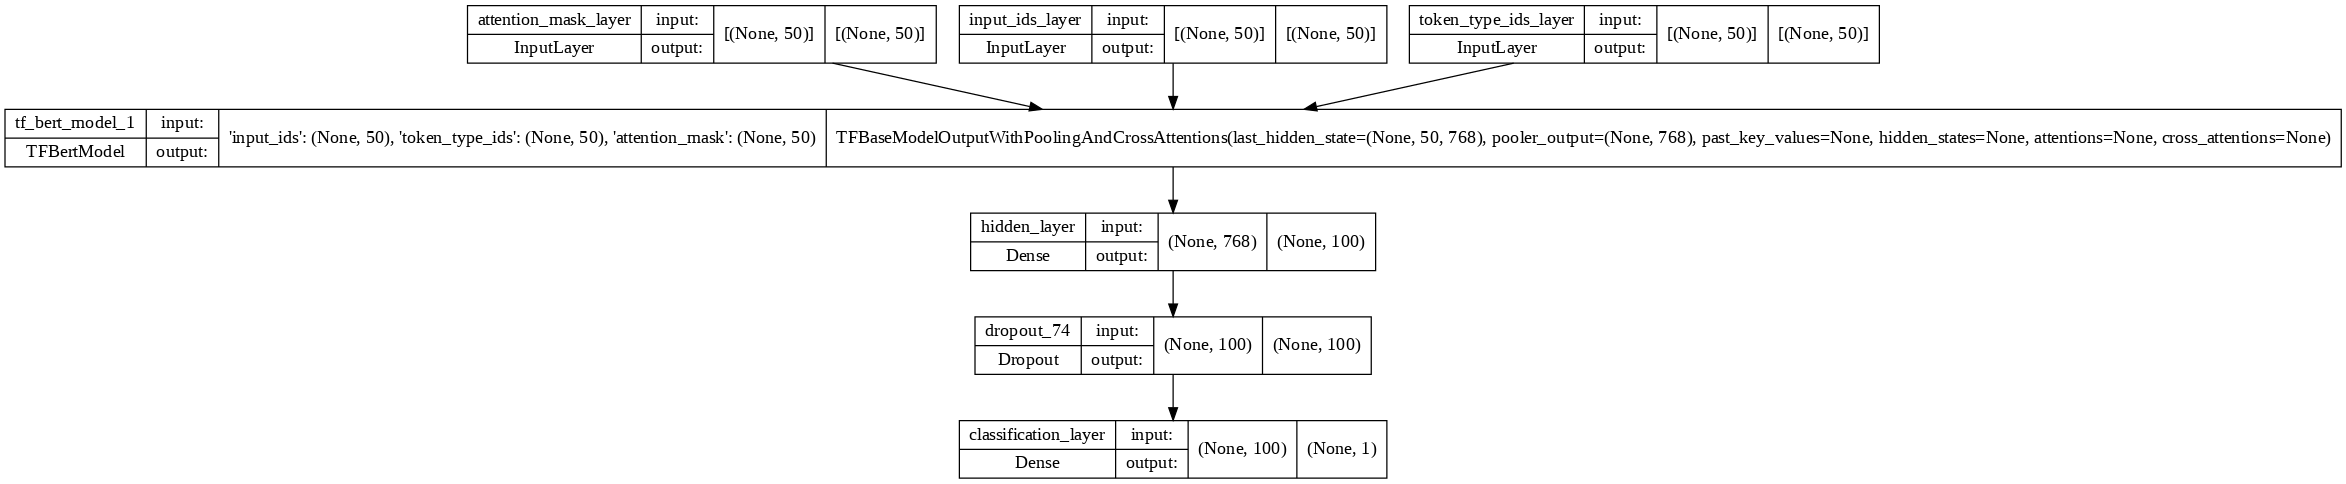

In [ ]:
keras.utils.plot_model(pooled_bert_model, show_shapes=True, dpi=90)

In [ ]:
pooled_bert_model_history = pooled_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                                                  y_train,   
                                                  validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),    
                                                  batch_size=8, 
                                                  epochs=5,
                                                  callbacks=[model_checkpoint_callback])  

Epoch 1/5
625/625 [==============================] - 79s 126ms/step - loss: 0.0884 - accuracy: 0.9718 - val_loss: 0.5472 - val_accuracy: 0.8430
Epoch 2/5
625/625 [==============================] - 74s 118ms/step - loss: 0.0705 - accuracy: 0.9776 - val_loss: 0.6075 - val_accuracy: 0.8400
Epoch 3/5
625/625 [==============================] - 73s 117ms/step - loss: 0.0464 - accuracy: 0.9854 - val_loss: 0.7950 - val_accuracy: 0.8420
Epoch 4/5
625/625 [==============================] - 73s 117ms/step - loss: 0.0557 - accuracy: 0.9832 - val_loss: 0.5457 - val_accuracy: 0.8410
Epoch 5/5
625/625 [==============================] - 77s 124ms/step - loss: 0.0430 - accuracy: 0.9874 - val_loss: 0.7311 - val_accuracy: 0.8450


In [ ]:
pooled_bert_model.layers

In [ ]:
score = pooled_bert_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test)

32/32 [==============================] - 4s 118ms/step - loss: 0.7311 - accuracy: 0.8450


##Save the Weights

In [ ]:
checkpoint_path= '/content/drive/MyDrive/'
checkpoint_file=checkpoint_path+'yelp_polarity_best_weights.h5'

# Save model weights
pooled_bert_model.save_weights(checkpoint_file)

In [ ]:
# Load trained model
# pooled_bert_model = tf.saved_model.load(checkpoint_file)
model = create_bert_pooled_model()
model.load_weights(checkpoint_file)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 50)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 50)]        0           []                               
 er)                                                                                              
                                                                                              

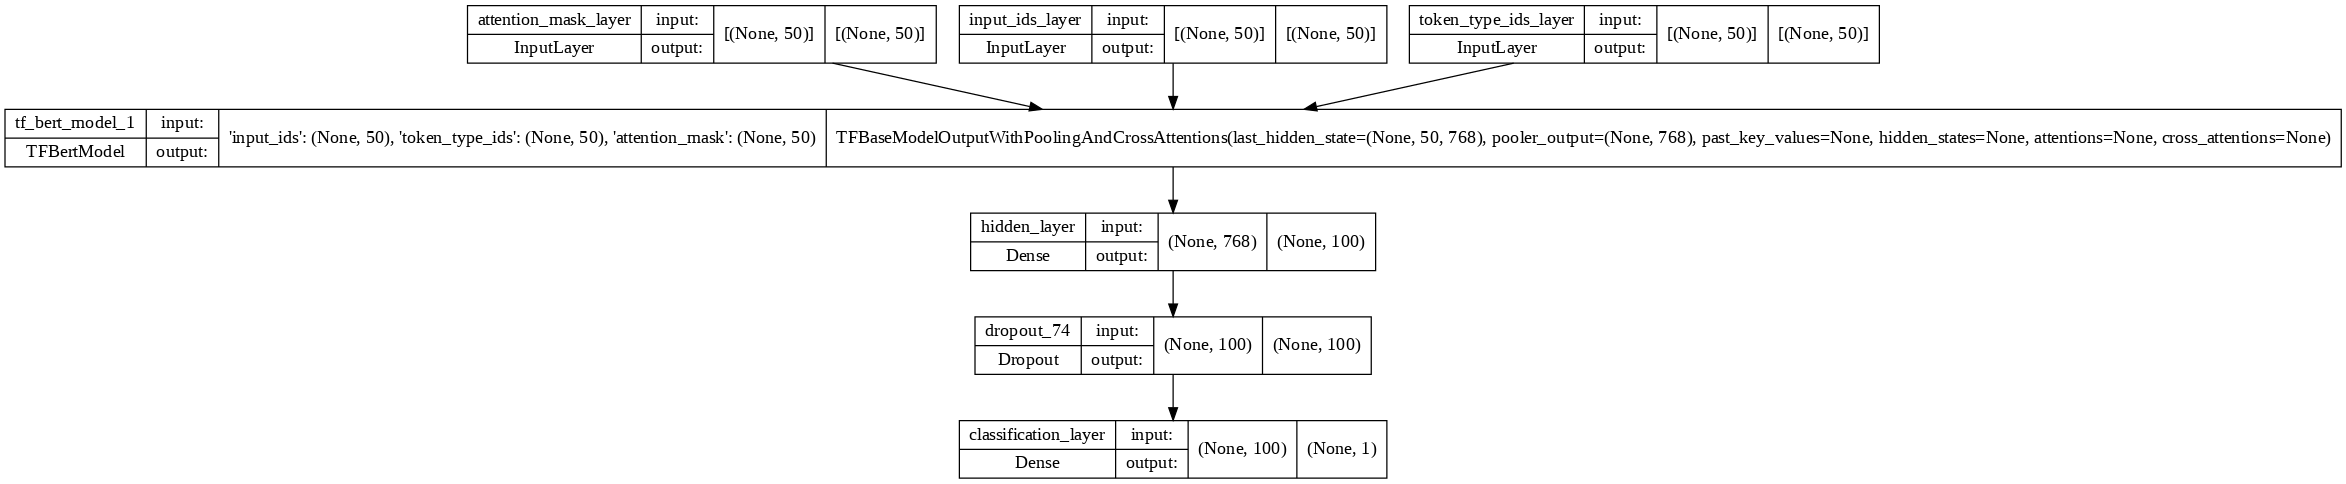

In [ ]:
keras.utils.plot_model(pooled_bert_model, show_shapes=True, dpi=90)

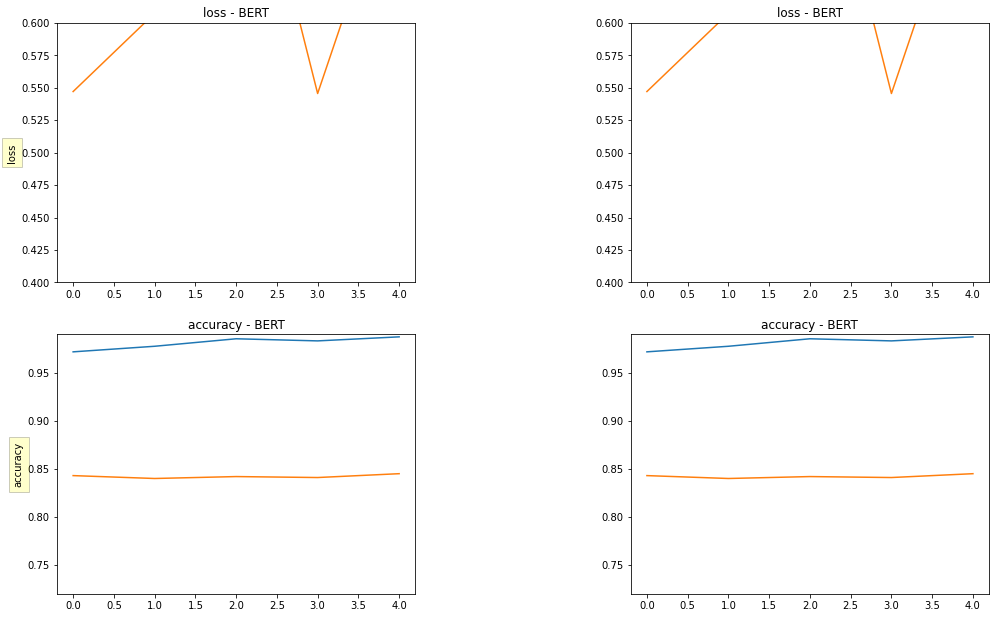

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          pooled_bert_model_history, 
          pooled_bert_model_history, 
          model_1_name='BERT',
         model_2_name='BERT',
         y_lim_accuracy_lower=0.72,
         y_lim_accuracy_upper=0.99)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
len(pooled_bert_model.weights)

203

In [ ]:
pooled_bert_model.weights[0].shape

TensorShape([28996, 768])

In [ ]:
pooled_bert_model.weights[0]

<tf.Variable 'tf_bert_model_1/bert/embeddings/word_embeddings/weight:0' shape=(28996, 768) dtype=float32, numpy=
array([[-0.00054784, -0.04156886,  0.01308366, ..., -0.0038919 ,
        -0.0335485 ,  0.0149841 ],
       [ 0.01688265, -0.03106827,  0.0042053 , ..., -0.01474032,
        -0.03561099, -0.0036223 ],
       [-0.00057234, -0.02673604,  0.00803954, ..., -0.01002474,
        -0.0331164 , -0.01651673],
       ...,
       [-0.00643814,  0.01658491, -0.02035619, ..., -0.04178825,
        -0.049201  ,  0.00416085],
       [-0.00483562, -0.00267701, -0.02901638, ..., -0.05116647,
         0.00449265, -0.01177113],
       [ 0.03134822, -0.02974372, -0.02302896, ..., -0.01454749,
        -0.05249038,  0.02843569]], dtype=float32)>